In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
from scipy.stats import zscore 
import statistics 
import matplotlib.pyplot as plt

# Team Ratings

When I think of madness, I think about modest teams beating champions and progressing far into the tournament. We all have a sense of the strength of teams when they face off. However, a way to quantify that strength is ideal for an analysis. Therefore, we will be using a [Massey Rating](https://en.wikipedia.org/wiki/Kenneth_Massey) in order to determine the relative strengths of the teams that will be facing off in every year's March Madness Tournament. Massey ratings are used widely in sports analytics and will give each team a rating that ranges from negative to positive values, where higher values represent a stronger rating. 

Below is the code to generate the Massey ratings for all teams that qualified for March Madness in a given year. I will use men's data and the year 2018 as an example.

In [ ]:
loc = ("/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
march_loc = ("/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv")
id_name_loc = ("/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MTeams.csv")

# Keys = team ID, vals = team name
id_to_name = {}

def id_name():
    with open(id_name_loc) as f:
        reader = csv.DictReader(f)
        # maps ID to name
        for row in reader:
            team_id = row["TeamID"]
            id_to_name[team_id] = row["TeamName"]

def massey(year, only_madness):
    id_name()
    teams = set({})
    num_games = 0
    with open(loc) as g:
        reader = csv.DictReader(g)
        for row in reader:
            if int(row['Season']) == year:
                teams.add(id_to_name[row['WTeamID']])
                teams.add(id_to_name[row['LTeamID']])
                num_games += 1
    id_matrix = {}
    matrix_id = 0
    teams = sorted(teams)
    # make teams into an index 
    for team in teams:
        id_matrix[team] = matrix_id
        matrix_id += 1
    # open games file
    # date, team, and score info
    teami = []; scorei = []; teamj = []; scorej = []
    with open(loc) as f:
        reader = csv.DictReader(f)
        for row in reader:
            if int(row['Season']) == year:
                current_i = id_matrix[id_to_name[row['WTeamID']]]
                current_j = id_matrix[id_to_name[row['LTeamID']]]
                s_i = int(row['WScore'])
                s_j = int(row['LScore'])
                # can be used later
                home_away = row['WLoc']
                teami.append(current_i)
                scorei.append(s_i)
                teamj.append(current_j)
                scorej.append(s_j)
    # Massey matrix and point differential vector
    numTeams = max(max(teami),max(teamj)) + 1
    m = np.zeros((numTeams,numTeams))
    p = np.zeros(numTeams)
    # k = 0
    for k in range(len(teami)):
        i = teami[k]
        j = teamj[k]
        # update massey matrix
        m[i,i] += 1; m[j,j] += 1
        m[i,j] += -1; m[j,i] += -1
        # update point differential vector
        p[i] += (scorei[k] - scorej[k])
        p[j] += (scorej[k] - scorei[k])
        # update k
        k += 1
    # solve Massey system
    m[-1,:] = 1
    p[-1] = 0
    r = np.linalg.solve(m,p)

    team_rating = []
    qualified = set({})
    with open(march_loc) as g:
        reader = csv.DictReader(g)
        for row in reader:
            if int(row['Season']) == year:
                qualified.add(id_to_name[row['WTeamID']])
                qualified.add(id_to_name[row['LTeamID']])
    for i in range(len(r)):
        if only_madness:
            if teams[i] in qualified:
                team_rating.append([teams[i],r[i]])
        else:
            team_rating.append([teams[i],r[i]])
    team_rating = sorted(team_rating, key = lambda x: x[1], reverse= True)

    return team_rating

massey(2018, True)

Now that we are able to quantify the relative strengths of teams, we can begin our analysis. 

# Quantifying Madness

Madness refers to outcomes that are unexpected. It refers to the games where an underdog faces a previous champion, and comes out victorious to the surprise of the crowd. Using our rating system, this would mean a lower team beating a higher rated team. Since we want to create a statistic that can quantify the madness in the March Madness tournament, we will want to look at all the games played in the tournament. 

March Madness happens in six single elimination stages. Here are the number of teams at each stage: 
* Stage 1: 68 teams 
* Stage 2: 32 teams 
* Stage 3: 16 teams 
* Stage 4: 8 teams 
* Stage 5: 4 teams 
* Stage 6: 2 teams 

If we take the average rating of the teams at each stage, we can get a sense of the general strength of the teams in that stage. If a season contains no madness whatsoever, we will expect the higher rated teams to win. This means a high average rating for all stages between 2 and 6. However, if a season is totally mad and underdogs are winning every single game, the average rating for all stages between 2 and stage 6 will be low.
> Every team in March Madness makes it to stage 1, therefore we do not take its average into account

So, our statistic for madness is going to be an average of the ratings that teams have in stage 2 through stage 6 inclusive. Before we use the ratings however, we must acknowledge that the Massey ratings are going to be different every year. For example, the range of Massey ratings might be -12 to 27 in one year but -15 to 24 in another year. Therefore, we want to **convert the Massey ratings of all teams into their corresponding z-scores**. 

This allows us to normalize the ratings for each year providing a better comparison across years. This way, the differences in ratings are going to be relative to the average of their respective year. A high z-score indicates an above average rating and a low z-score indicates a below average rating. This way a team with a z-score of 1 can be approximated to a team with a z-score of 1 on another year. 

The average at each stage should also be weighted. A team that makes it to the finals (stage 6) is much more impressive than a team that simply makes it past the first round (stage 2). Therefore, we want to take a weighted average of the stages between stage 2 - stage 6. How we will weight is based on the inverse of the number of teams that make it to that round. So, the average of the teams that made it to stage 6 will count 16 times more than the average of the teams that made it to stage 2 in the computation of our overall tournament average. 

**Madness Statistic Weighted Average = (average z-score of teams in stage 2 - stage 6) * (corresponding weights)**

Therefore, a high weighted average for a year indicates that teams with high ratings relative to the average that year made it far into the tournament. This is an indication that the tournamnet was not very mad or unexpected that year. On the other hand, if we have a weighted average that is low, it indicates that teams with ratings below average made it far into the tournament. And in order for that to happen, it must have been a tournament full of madness.

Below is the code required to run our measurement. Men's data is used for this example. The output is small, so I have commented out the last line that generates the graph. To see it, simply uncomment out the last line.

In [ ]:
loc = ("/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
march_loc = ("/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MNCAATourneyCompactResults.csv")
id_name_loc = ("/kaggle/input/march-madness-analytics-2020/2020DataFiles/2020DataFiles/2020-Mens-Data/MDataFiles_Stage1/MTeams.csv")

# Keys = team ID, vals = team name
id_to_name = {}

name_to_id = {}

def id_name():
    with open(id_name_loc) as f:
        reader = csv.DictReader(f)
        # maps ID to name
        for row in reader:
            team_id = row["TeamID"]
            id_to_name[team_id] = row["TeamName"]
            name_to_id[row["TeamName"]] = int(row["TeamID"])
            
def massey(year, only_madness):
    teams = set({})
    num_games = 0
    with open(loc) as g:
        reader = csv.DictReader(g)
        for row in reader:
            if int(row['Season']) == year:
                teams.add(id_to_name[row['WTeamID']])
                teams.add(id_to_name[row['LTeamID']])
                num_games += 1
            if int(row['Season']) > year:
                break
    id_matrix = {}
    matrix_id = 0
    teams = sorted(teams)
    # make teams into an index 
    for team in teams:
        id_matrix[team] = matrix_id
        matrix_id += 1
    # open games file
    # date, team, and score info
    teami = []; scorei = []; teamj = []; scorej = []
    with open(loc) as f:
        reader = csv.DictReader(f)
        for row in reader:
            if int(row['Season']) == year:
                current_i = id_matrix[id_to_name[row['WTeamID']]]
                current_j = id_matrix[id_to_name[row['LTeamID']]]
                s_i = int(row['WScore'])
                s_j = int(row['LScore'])
                # can be used later
                home_away = row['WLoc']
                teami.append(current_i)
                scorei.append(s_i)
                teamj.append(current_j)
                scorej.append(s_j)
    # Massey matrix and point differential vector
    numTeams = max(max(teami),max(teamj)) + 1
    m = np.zeros((numTeams,numTeams))
    p = np.zeros(numTeams)
    # k = 0
    for k in range(len(teami)):
        i = teami[k]
        j = teamj[k]
        # update massey matrix
        m[i,i] += 1; m[j,j] += 1
        m[i,j] += -1; m[j,i] += -1
        # update point differential vector
        p[i] += (scorei[k] - scorej[k])
        p[j] += (scorej[k] - scorei[k])
        # update k
        k += 1
    # solve Massey system
    m[-1,:] = 1
    p[-1] = 0
    r = np.linalg.solve(m,p)

    team_ratings = []
    team_ids = []
    qualified = set({})
    with open(march_loc) as g:
        reader = csv.DictReader(g)
        for row in reader:
            if int(row['Season']) == year:
                qualified.add(id_to_name[row['WTeamID']])
                qualified.add(id_to_name[row['LTeamID']])
    for i in range(len(r)):
        if only_madness:
            if teams[i] in qualified:
                team_ratings.append(r[i])
                team_ids.append(name_to_id[teams[i]])

    team_zscores = zscore(team_ratings)

    """ Cinderella Analysis """

    # maps team ids to their massey ratings zscores
    id_zscore = {}

    for i in range(len(team_ids)):
        id_zscore[team_ids[i]] = team_zscores[i]

    # 32 teams 
    day_138_139 = []
    weight_32 = 1/31    
    # 16 teams 
    day_143_144 = []
    weight_16 = 2/31
    # 8 teams 
    day_145_146 = []
    lowest_145_146 = 100
    weight_8 = 4/31
    # 4 teams 
    day_152 = []
    lowest_152 = 100
    weight_4 = 8/31
    # 2 teams final 
    day_154 = []
    lowest_154 = 100
    weight_2 = 16/31

    with open(march_loc) as g:
        reader = csv.DictReader(g)
        for row in reader:
            if int(row['Season']) == year:
                current_day = row['DayNum']
                team_1 = int(row['WTeamID'])
                team_2 = int(row['LTeamID'])
                if current_day == '138' or current_day == '139':
                    day_138_139.append(id_zscore[team_1])
                    day_138_139.append(id_zscore[team_2])
                elif current_day == '143' or current_day == '144':
                    day_143_144.append(id_zscore[team_1])
                    day_143_144.append(id_zscore[team_2])
                elif current_day == '145' or current_day == '146':
                    day_145_146.append(id_zscore[team_1])
                    day_145_146.append(id_zscore[team_2])
                    lowest = min(lowest_145_146,id_zscore[team_1],id_zscore[team_2])
                    lowest_145_146 = lowest
                elif current_day == '152':
                    day_152.append(id_zscore[team_1])
                    day_152.append(id_zscore[team_2])
                    lowest = min(lowest_152,id_zscore[team_1],id_zscore[team_2])
                    lowest_152 = lowest
                elif current_day == '154':
                    day_154.append(id_zscore[team_1])
                    day_154.append(id_zscore[team_2])
                    lowest = min(lowest_154,id_zscore[team_1],id_zscore[team_2])
                    lowest_154 = lowest

    weighted_zscore_average = 0
    weighted_zscore_average += weight_32 * statistics.mean(day_138_139)
    weighted_zscore_average += weight_16 * statistics.mean(day_143_144)
    weighted_zscore_average += weight_8 * statistics.mean(day_145_146)
    weighted_zscore_average += weight_4 * statistics.mean(day_152)
    weighted_zscore_average += weight_2 * statistics.mean(day_154)

    return [weighted_zscore_average, lowest_154]

def plot_weighted_average():
    id_name()
    n_groups = 0
    weighted_zscore = []
    Lowest_Zscore_Final  = []
    x_labels = []

    for year in range(1985,2020):
        r = massey(year,True)
        n_groups += 1
        weighted_zscore.append(r[0])
        Lowest_Zscore_Final.append(r[1])
        x_labels.append("'" + str(year)[-2:])

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = plt.bar(index, weighted_zscore, bar_width,
    alpha=opacity,
    color='b',
    label='Weighted Z-Score')

    rects2 = plt.bar(index + bar_width, Lowest_Zscore_Final , bar_width,
    alpha=opacity,
    color='g',
    label='Finals Lowest Zscore')

    plt.xlabel('Year')
    plt.ylabel('Z-Score')
    plt.title('Z-Scores vs. Year (Men\'s)')
    plt.xticks(index + bar_width, x_labels)
    plt.legend()

    plt.tight_layout()
    plt.show()

# plot_weighted_average()

# Results

Weighted Average Z-Score for Men's Data

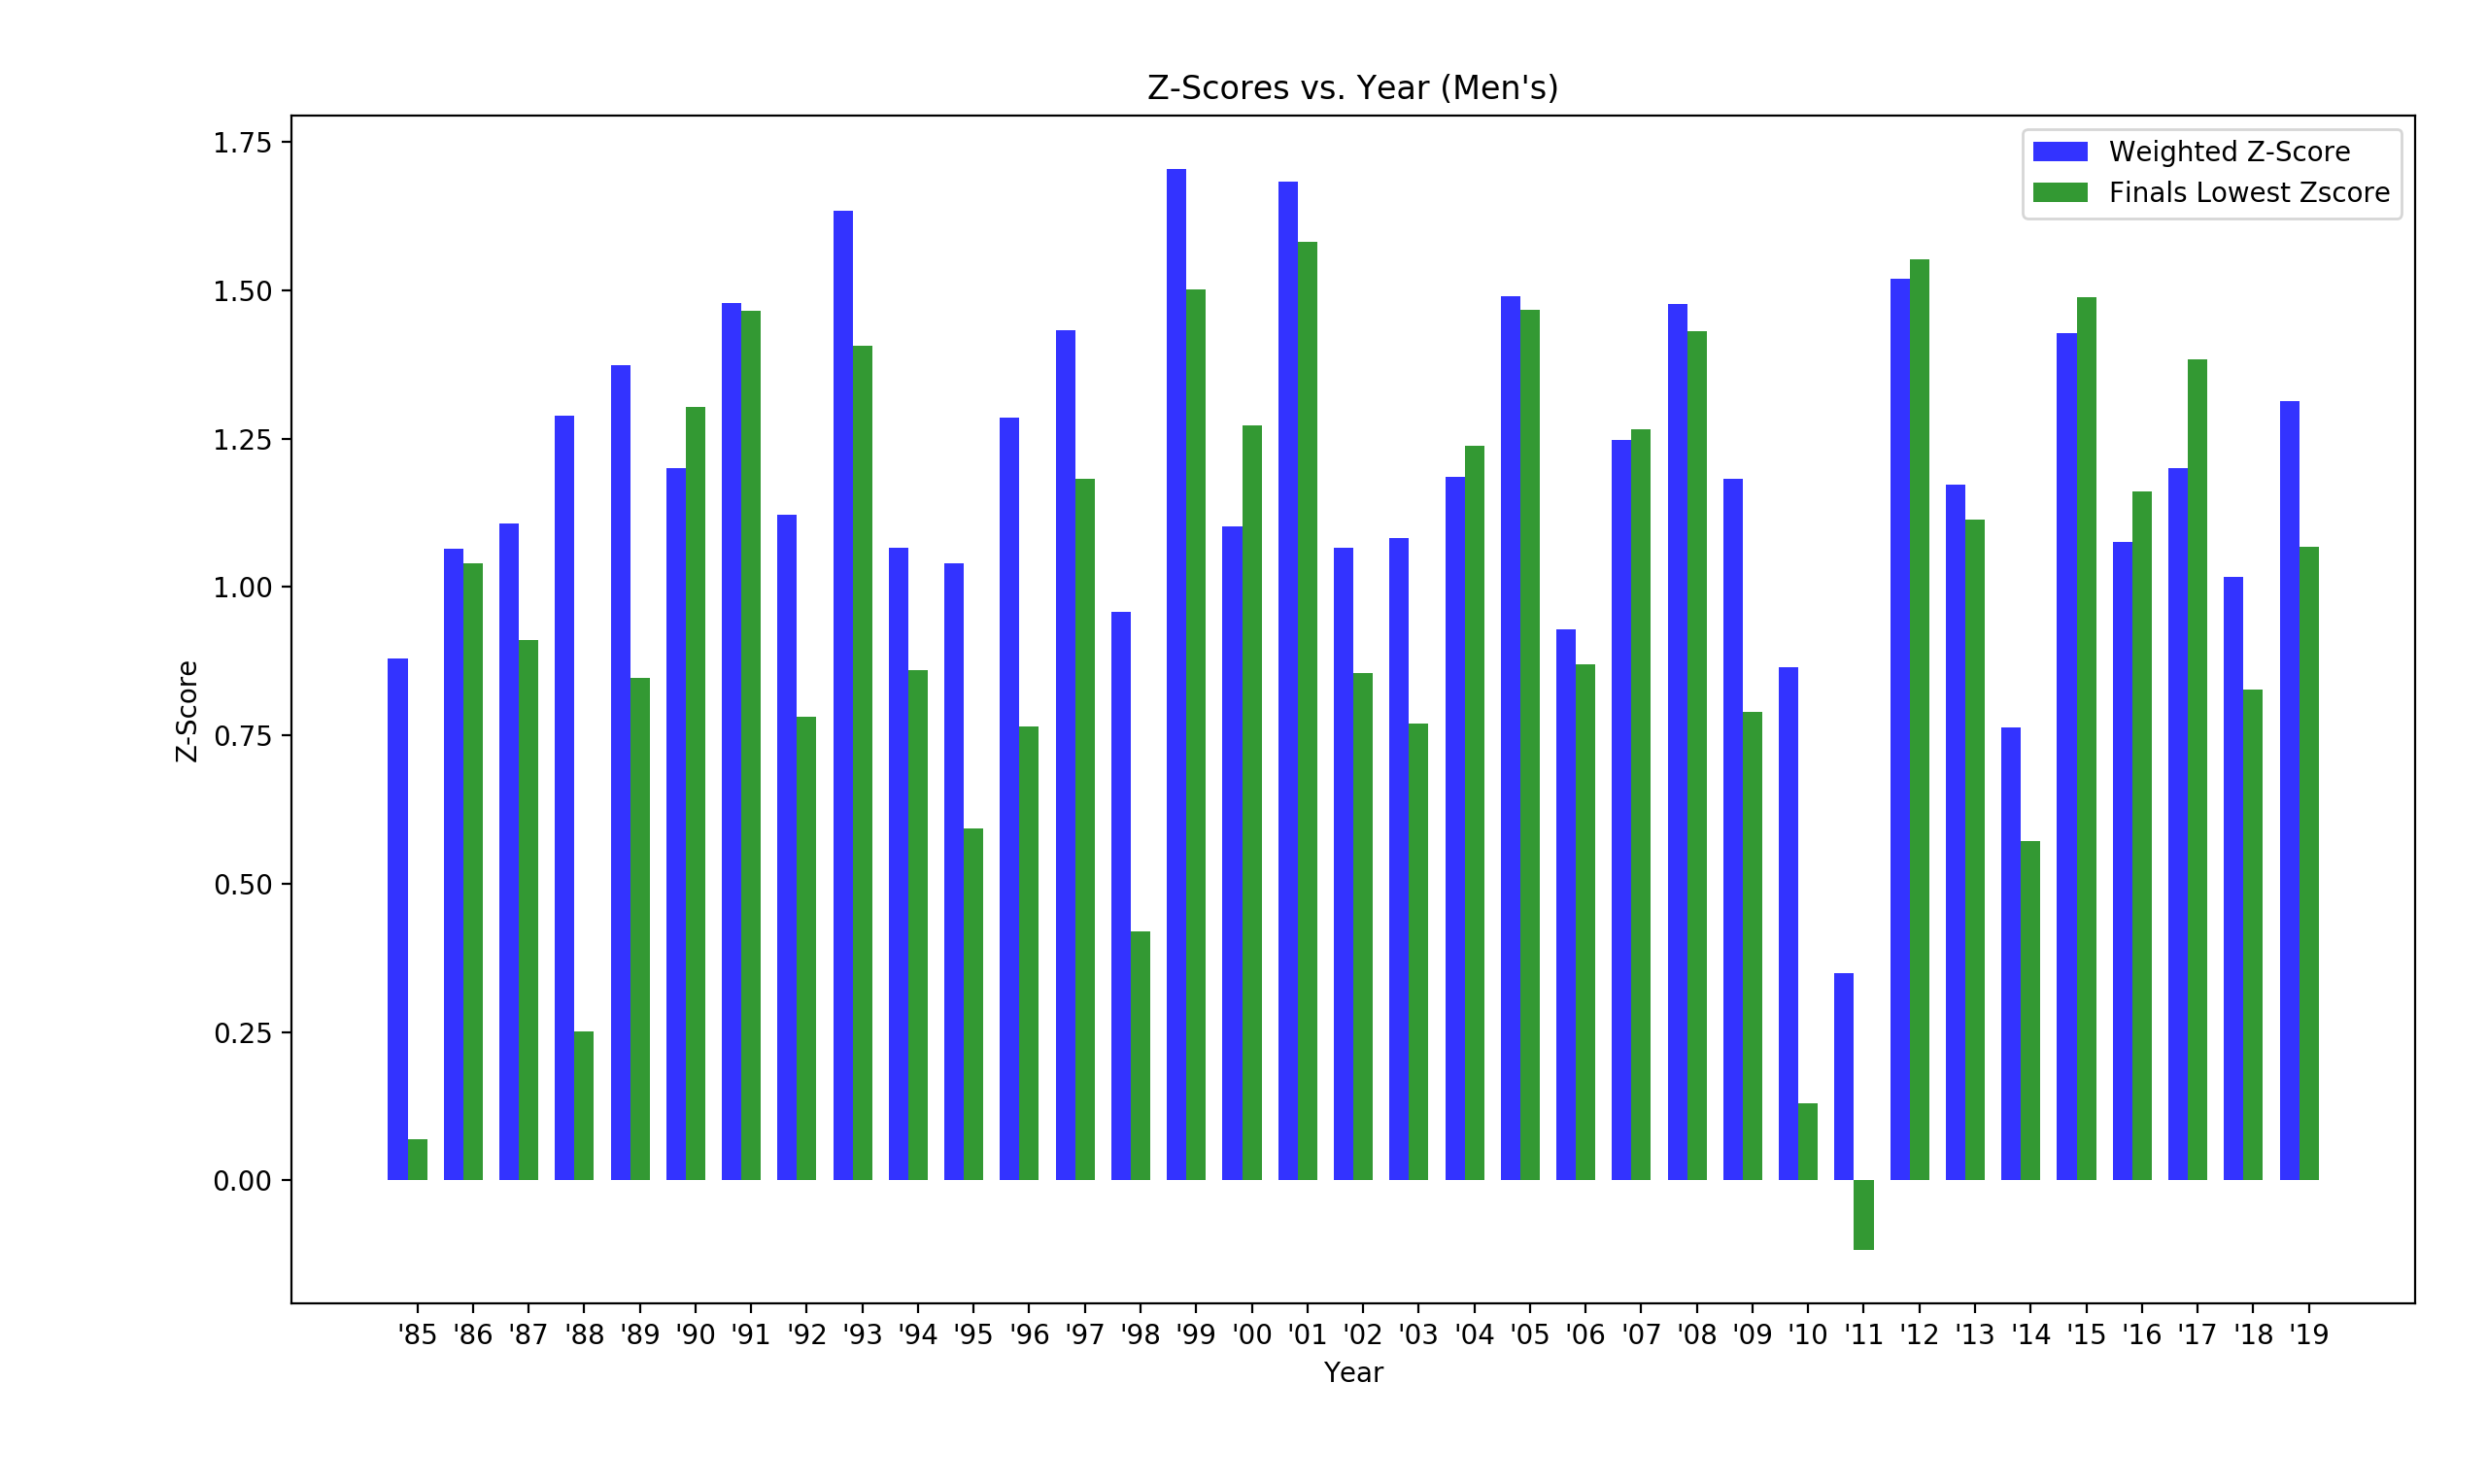

Weighted Average Z-Score for Women's Data

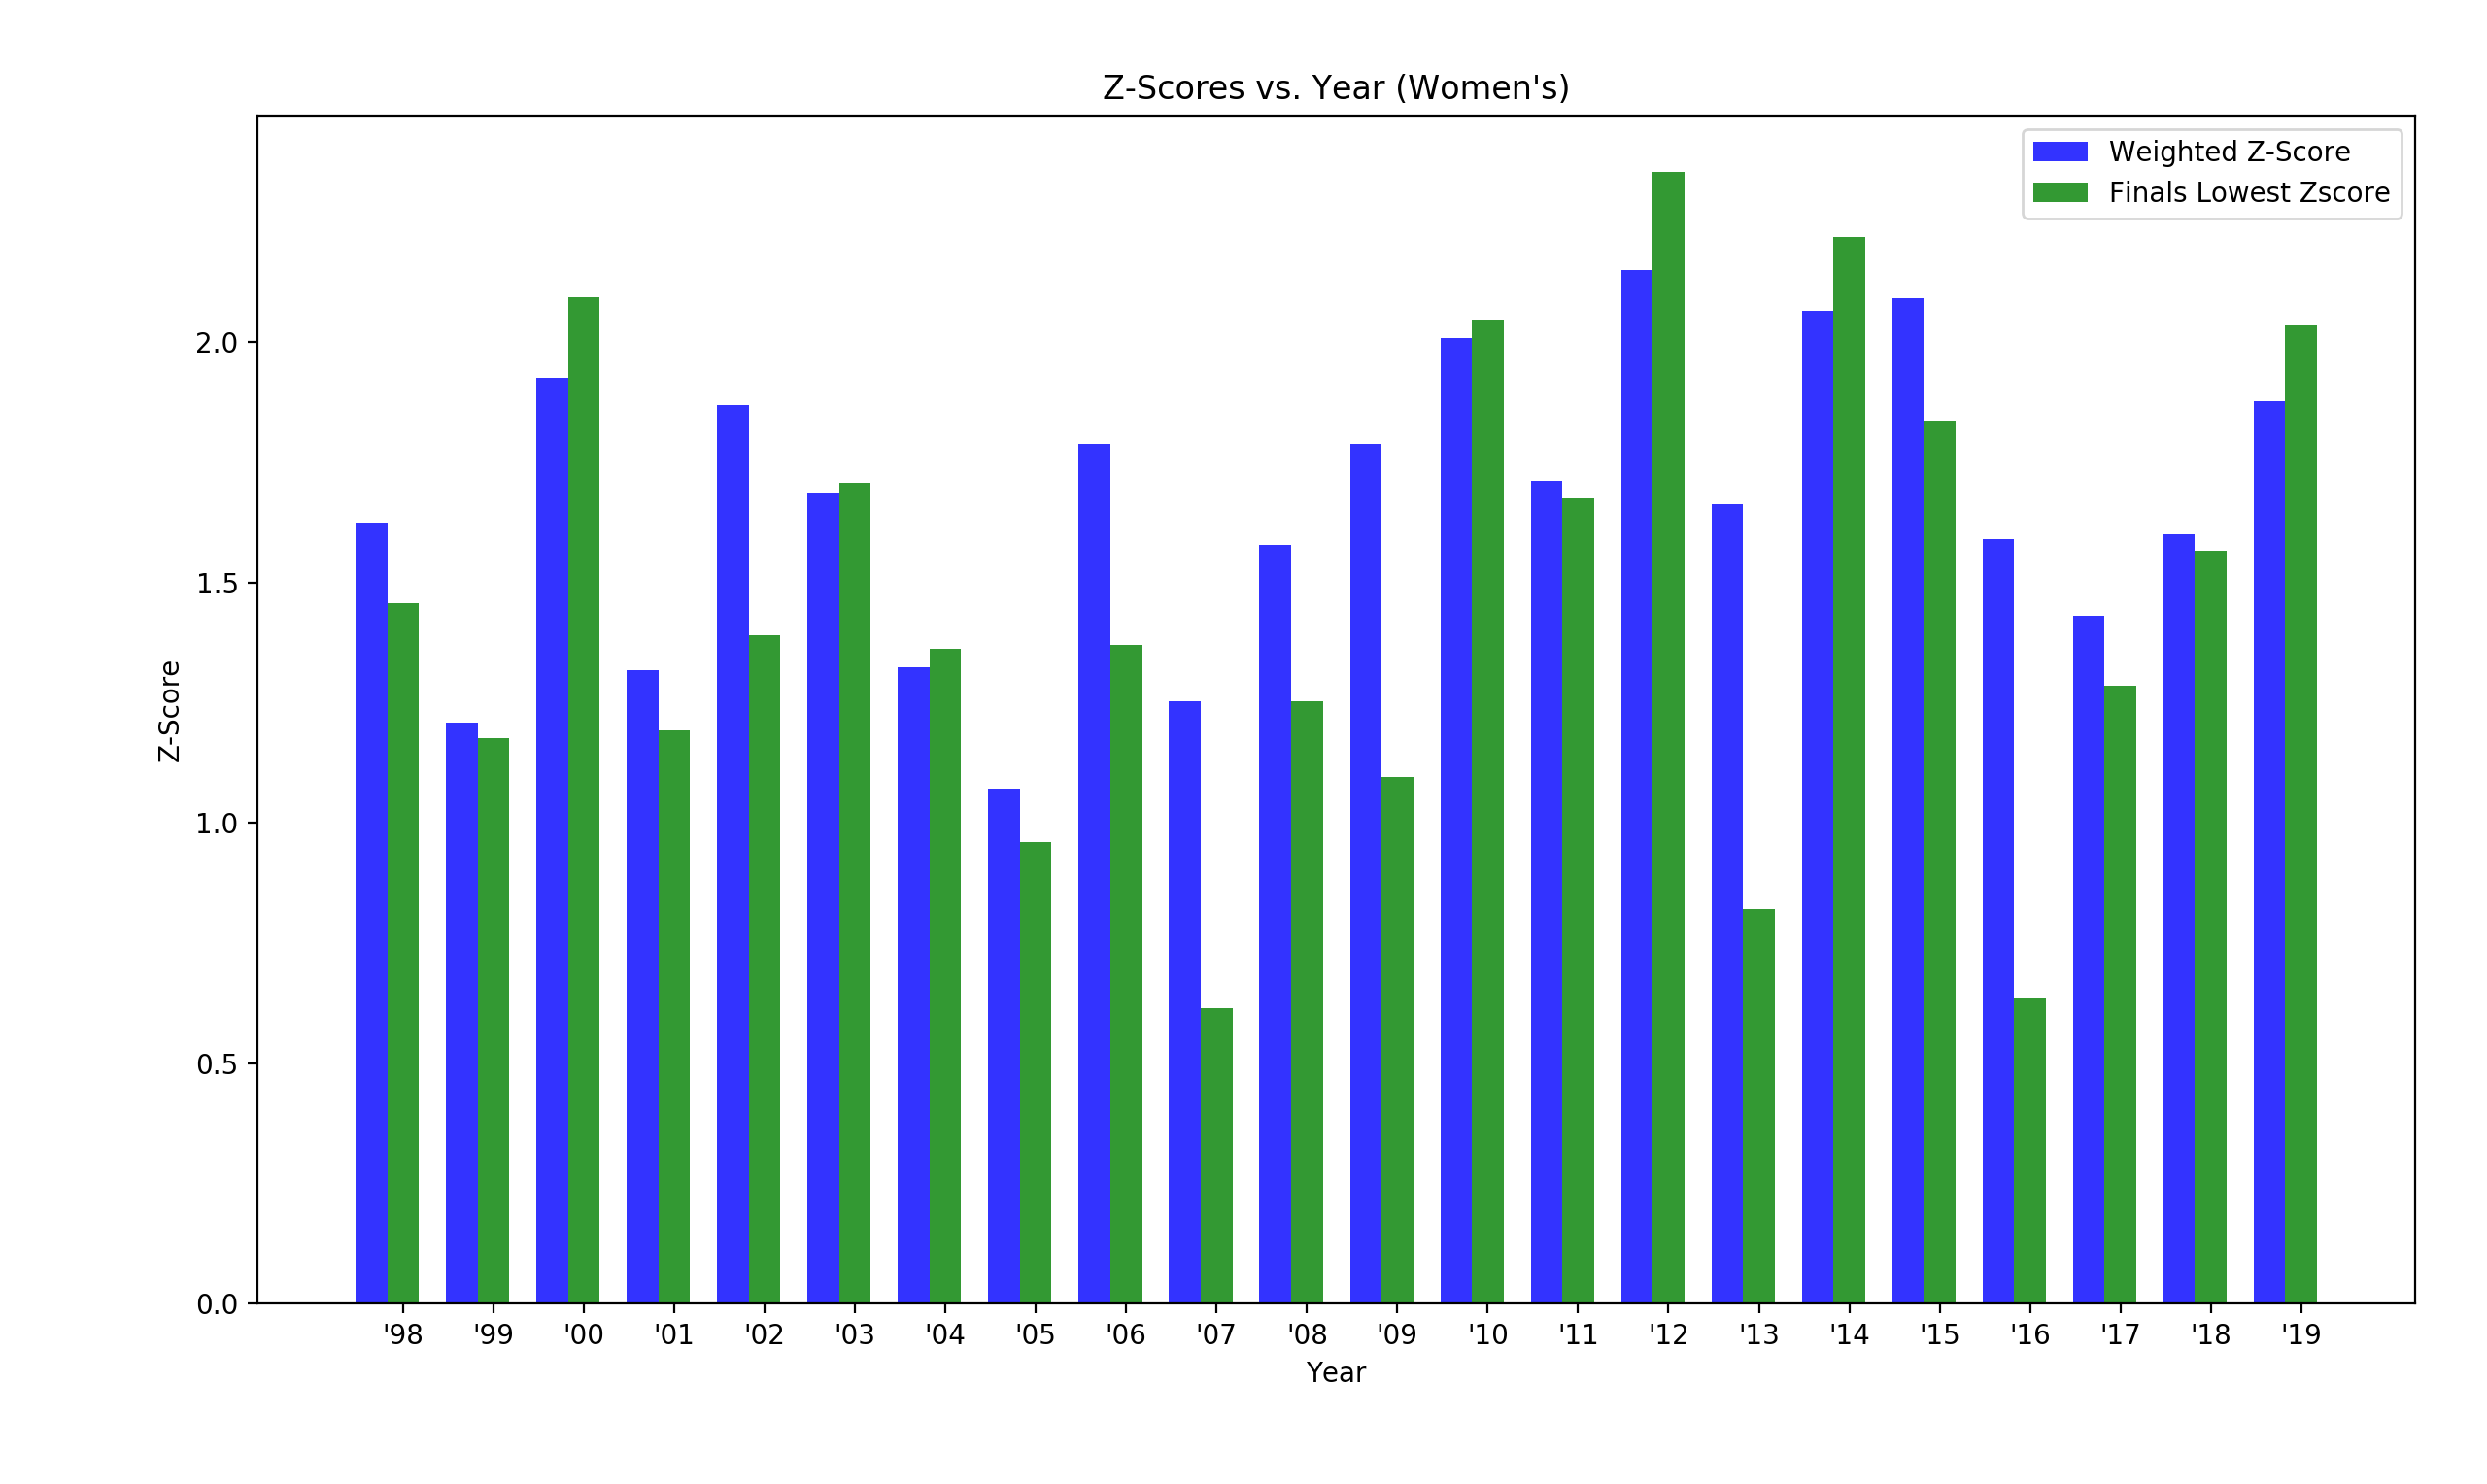

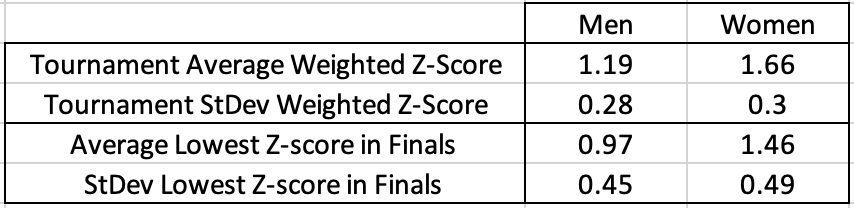
> Finals lowest z-score refers to the z-score of the lower rated team in the finals. It tells us whether or not there was an underdog in the finals game for that year's tournament. In the graph, it is represented in green.

From our table we can see that the average weighted z-score is quite high for both men and women averaged across the years. This is not surprising since we expect higher rated teams to progress further in most years. However, it is quite striking how much higher the mean weighted average is for women than it is for men. The standard deviation is quite similar for both of them, so it does seem to indicate that there is a difference between the two. A similar trend can be seen for the average lowest z-score in finals. The article “[Why NCAA Men’s Basketball Has More Upsets Than Women’s Basketball](https://thefederalist.com/2017/03/15/ncaa-mens-basketball-upsets-womens-basketball/)” makes similar observations to my analysis.

> Men's March Madness seems to feature more upsets than women's

# The Maddest of Them All and the Least

We can see that the year 2011 in men's March Madness had the lowest weighted z-score and the lowest z-score appearance in a final's game. The wikipedia page for that year seems to agree with our analysis, as it states that "[upsets ruled the 2011 tournament](https://en.wikipedia.org/wiki/2011_NCAA_Division_I_Men%27s_Basketball_Tournament)". 

On the other end, the year 2012 in the women's tournament featured the highest weighted z-score and highest z-score appearance in a final's game. This means that the results were most likely highly predictable with the highest rated teams progressing far into the tournament. The wikipedia page for the 2012 women's tournament states that "[for only the second time in history, and the first time since 1989, all four of the number one seeds made it to the Final Four](https://en.wikipedia.org/wiki/2012_NCAA_Division_I_Women%27s_Basketball_Tournament)," confirming our findings. 

# Closer Look

Let's take a closer look at the March Madness games that were played in 2011 in the men's tournament and 2012 for the women's tournament. To dig deeper into our analysis, we can look at the progression of the teams throughout the stages in each respective tournament. In order to do this, I will use a violin plot to highlight the distributions of the teams as the tournament progresses. For this visualization, [D3.js](https://www.d3-graph-gallery.com/graph/violin_jitter.html) was used for its capabilitity of rendering a beautiful violin plot. The data inputted is the same as what was used to plot the weighted z-scores. 

The individual rating z-scores have colors from blue to red, indicating below average to above average ratings respectively. 

Men's 2011 tournament z-scores vs. stages

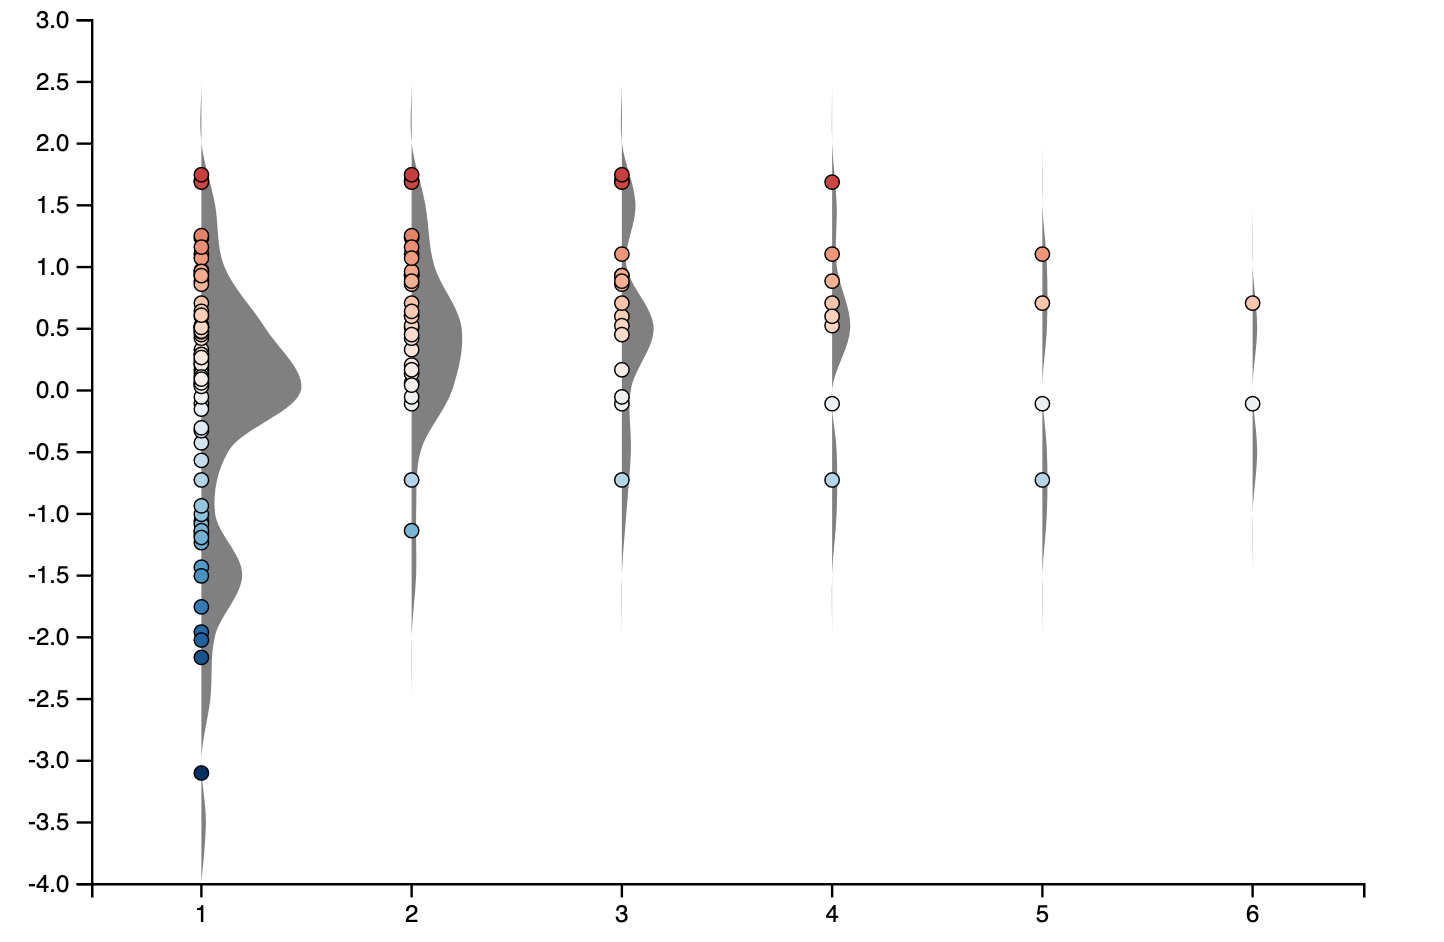

For the men's data we see that in stage 1, the 68 teams form a bi-modal distribution with one peak around 0 and another peak around -1.5. This indicates that there are ratings clustered around that region. Immediately after stage 1, we see that the lower peak is almost completely lost, as all but two of the lowest rated teams are eliminated from the tournament. Additionaly, in stages 4 and 5, we see that two relatively low rated teams remaining; one team with a slightly below average team rating and another with a rating almost one standard deviation below the average. It is unusual to observe that these two teams still made it to stage 5 considering 64 of the 68 teams have already been eliminated. Moreover, plenty out of those eliminated had much higher ratings. We can see how incredible this is when we compare it to the 2012 results for the women's tournamnet. 

Women's 2012 tournament z-scores vs. stages

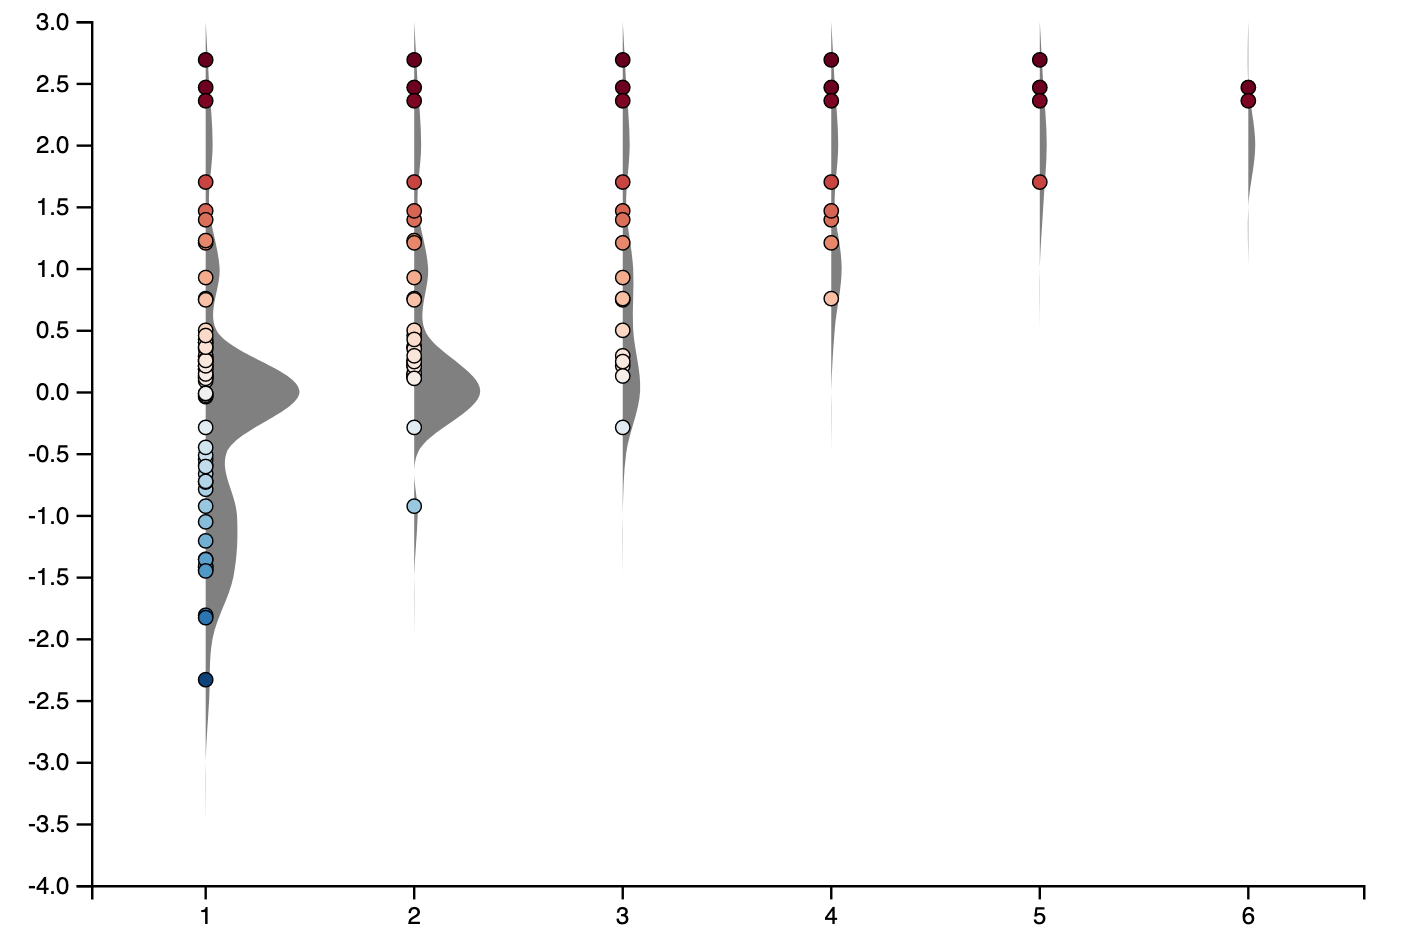

We see that the 2012 women's tournament start off similarly to the men's 2011 tournament. A bi-modal distribution with a peak around 0 and another peak around -1 is apparent. Likewise, the lower peak is almost entirely eliminated after stage 1. We can start to see the stark contrast starting at stage 3. The peak around 0 is almost completely lost meaning that teams with average ratings were eliminated. Then, starting at stage 4 only the highest rated teams remain. 

From our deeper dive into the violin plots, we observe that the triangle shape of the women's 2012 tournament indicates years with no madness where the highest rated teams never seemed to lose. On the contrary, the more flag shaped contour of the men's 2011 tournament suggests upsets and madness, as the highest rated teams get eliminated and seemingly average teams progress deep into the tournament. 

# Recap

In this notebook we can have accomplished two things. 

1. We were able to devise a metric to quantify the madness using a weighted z-score average of team ratings for every year. A higher weighted average indicates that higher rated teams progressed far into the tournament, crushing any lower rated teams. By contrast, a lower weighted average would incidcate a year of madness as lower rated teams progressed deep into the tournament. We were able to validate our metric using analyses from Wikipedia. 

2. We took a deeper look into the progression of the individual tournaments using violin plots. Looking at the development during each stage we could see the madness unfolding. We also looked at the shapes as another indicator for madness.